# Introduction 

##### Food insecurity in America is rampant, with the USDA reporting that over 13.5% of American households faced food insecurity in 2023 (Link). A rampant increase from previous years. The effects of food insecurity are devastating. Feeding America, a non-profit organization combating food insecurity in America, reports that from households facing food insecurity, 66% had to choose between food and medical care, 57% had to choose between food and housing, and 31% had to choose between food and education (Link). These effects have also been shown to be dependent on the demographic of the population. This leads us to ask the questions 

##### * Who is affected by food insecurity? 
##### *  Why is food insecure in an area?
##### * What is the correlation between food insecurity and data points? 


# The Data

I pulled the dataset "Food Access Research Atlas" from the USDA(U.S Department Of Agriculture). A dataset that includes 147 columns and 72530 rows. It tracts location data including census tract, state, and county. It has distance relative to low acess to food and population demographic data. 

###### 

# Pre-Processing Data

##### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler




##### Importing our data set and creating a dataframe

In [ ]:
#Dataset
uncleaned_atlas_df = pd.read_csv("/Users/anthonymanzo-trinidad/Documents/ITCS-3162_Project1/Food Access Research Atlas.csv")
#Datasets for variable lookup
variables = pd.read_csv("/Users/anthonymanzo-trinidad/Documents/ITCS-3162_Project1/VariableLookup.csv")

##### Checking for null values and data types

In [ ]:
uncleaned_atlas_df.isnull().sum().sort_values(ascending=False)
uncleaned_atlas_df.info()

##### The most important features from our dataset are Censu Tract, State, Tract median family income, Tract poverty rate, Low income tract. As such we will drop any rows that do not have all of these features complete. 

In [9]:
cleaned_atlas_df = uncleaned_atlas_df.dropna(subset=['CensusTract','State','County','Urban','LowIncomeTracts','MedianFamilyIncome','PovertyRate'])


##### We were able to drop around 1000 entries from our dataset. This is important because we will being using this cleaned dataset as the base for our further processed datasets to get greater insight on features that a greater amount of nulls.

##### After that, we will focus on features that act as low-access indicators and drop those that have null values for these features. We drop these features because they are essential for my analysis, and filling in with synthetic data from imputation is not necessary with the low amount of null values present in the dataset for these features.


In [ ]:
demo_atlas_df = cleaned_atlas_df.dropna(subset=["LILATracts_1And10", "LILATracts_halfAnd10", "LILATracts_1And20", "LILATracts_Vehicle"])
demo_atlas_df.info()

##### We must then focus on features that explore the demographics of those who experience food insecurity and drop any null values. These are essential to our data analysis, and we would only be dropping one single row, so I felt it was best not to do a form of imputation. 

In [ ]:
final_atlas_df = demo_atlas_df.dropna(subset=["Pop2010","TractWhite","TractBlack","TractAsian","TractNHOPI","TractAIAN","TractOMultir","TractHispanic"])
final_atlas_df.info()

##### Next, we will focus on low-access metrics for each demographic. Each demographic has null values at random; however, it is noticeable that we can use other metrics from each row to fill in any null values with k-nearest neighbor imputation using a minmax scaler. Even if these metrics are essential to our analysis, dropping null values from these features would greatly affect the size of our dataset. 

In [ ]:
cols_to_impute = ["lahisp10","lablack10","laasian10","lanhopi10","laaian10","lawhite10"]

scaler = MinMaxScaler()

imputer = KNNImputer(n_neighbors=5)

final_atlas_df[cols_to_impute] = imputer.fit_transform(scaler.fit_transform(final_atlas_df[cols_to_impute]))
final_atlas_df[cols_to_impute] = scaler.inverse_transform(final_atlas_df[cols_to_impute])
final_atlas_df[cols_to_impute].isnull().sum()

## Feature Enginering

##### We will create a new column with the proportion of each demographic. This column will help in the process of creating visuals that explore demographic makeup. The demographic percentage will be calculated using the tract for each demographic by the total population.

In [ ]:
final_atlas_df["HISPCT"]  = final_atlas_df["TractHispanic"] / final_atlas_df["Pop2010"] * 100

final_atlas_df["BLACKPCT"] = final_atlas_df["TractBlack"] / final_atlas_df["Pop2010"] * 100

final_atlas_df["WHTPCT"]  = final_atlas_df["TractWhite"] / final_atlas_df["Pop2010"] * 100

final_atlas_df["ASIANPCT"] = final_atlas_df["TractAsian"] / final_atlas_df["Pop2010"] * 100

final_atlas_df["NHOPIPCT"] = final_atlas_df["TractNHOPI"] / final_atlas_df["Pop2010"] * 100

final_atlas_df["AIANPCT"]  = final_atlas_df["TractAIAN"] / final_atlas_df["Pop2010"] * 100

##### We will then create a dictionary that holds the low access metrics and percentages for demographic groups. This just makes it easier to parse through our dataset when creating visuals.

In [ ]:
groups = {
    'Hispanic': {'pct':'HISPCT', 'la':'lahisp10'},
    'Black':    {'pct':'BLACKPCT', 'la':'lablack10'},
    'White':    {'pct':'WHTPCT', 'la':'lawhite10'},
    'Asian':    {'pct':'ASIANPCT', 'la':'laasian10'},
    'NHOPI':   {'pct':'NHOPIPCT', 'la':'lanhopi10'},
    'AIAN':     {'pct':'AIANPCT', 'la':'laaian10'},
}

##### Then we will create a new column that indicates the low access rate(percentage) for each row, which is calculated by the low access population divided by the population total. Needed for visuals. 

In [ ]:
final_atlas_df['lowacc_rate'] = (final_atlas_df['lapop10'] / final_atlas_df['Pop2010']).clip(lower=0, upper=1)

In [ ]:
final_atlas_df["State"].value_counts()
top10States = final_atlas_df["State"].value_counts().nlargest(10).index.tolist()
final_atlas_df["top10States"] = final_atlas_df["State"].apply(lambda x: x if x in top10States else "Other")

## Visualizations

### Correlation Heatmap Of Basic Features

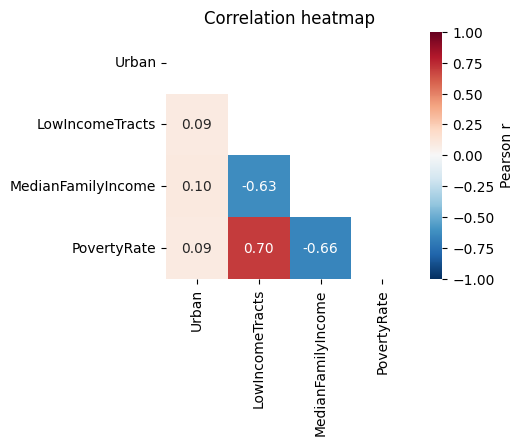

In [60]:
num = final_atlas_df[['Urban','LowIncomeTracts','MedianFamilyIncome','PovertyRate']].apply(pd.to_numeric, errors='coerce')
corr = num.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(5.5,4.5))
sns.heatmap(corr, annot=True, fmt='.2f', vmin=-1, vmax=1, center=0,
            cmap='RdBu_r', mask=mask, square=True, cbar_kws={'label':'Pearson r'})
plt.title('Correlation heatmap')
plt.tight_layout()
plt.show()


##### Through the correlation heatmap we see strong to moderate correlation between food insecurity and poverty, food insecurity and the rural demographic, food insecurity and household income. This give us a entry level understanding to what causes food insecurity. 

### Urban vs Rural Food Insecurity Tracts

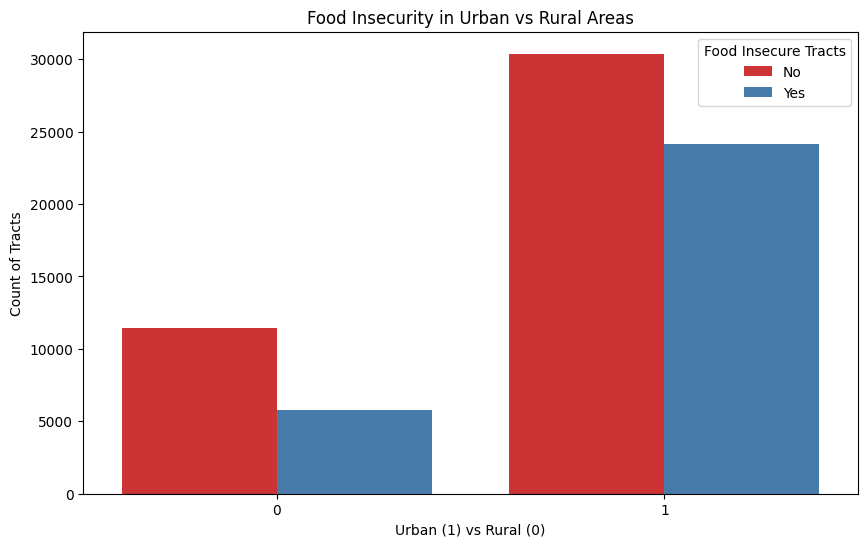

In [58]:
plt.figure(figsize=(10,6))
sns.countplot(data=cleaned_atlas_df, x='Urban', hue='LowIncomeTracts', palette='Set1')
plt.title('Food Insecurity in Urban vs Rural Areas')
plt.xlabel('Urban (1) vs Rural (0)')
plt.ylabel('Count of Tracts')
plt.legend(title='Food Insecure Tracts', labels=['No', 'Yes'])
plt.show()

##### Our visual presents the difference between the share of those who experience food insecurity in urban and rural areas. At first glance we see that the rural demographic makes up a majority of data’s population with them having a high percentage of food insecurity present. The urban population is smaller and has a low percentage of food insecurity. This helps me get to an answer to my question on who is facing food insecurity. This showcases that the rural demographic seems to be a disadvantage in accessing food. Further data on their access to grocery stores, economic makeup, and access to transportation could give insight into why they face greater food insecurity. 


### Urban vs Rural Low-Access Rate for the 10 Most Populated States and others

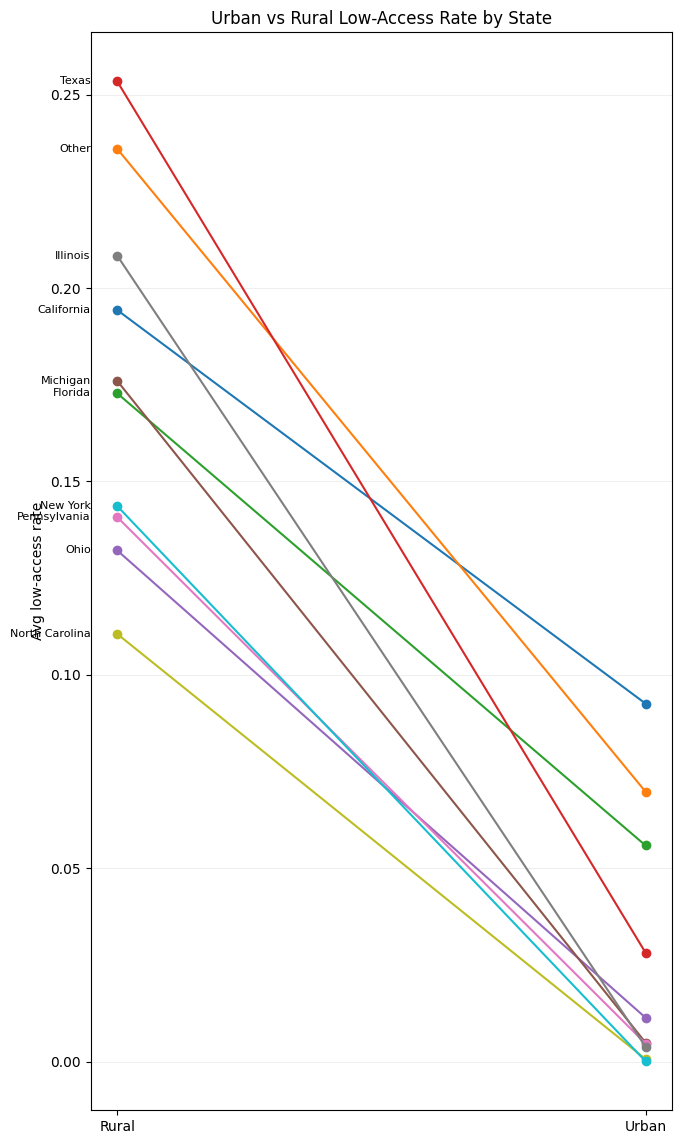

In [57]:
#Grouping by state and urban/rural, then average low-access rate
by = final_atlas_df.groupby(['top10States','Urban'], as_index=False)['lowacc_rate'].mean()
wide = by.pivot(index='top10States', columns='Urban', values='lowacc_rate').rename(columns={0:'Rural',1:'Urban'}).dropna()

plt.figure(figsize=(7.5,14))
for i,(st,row) in enumerate(wide.sort_values('Urban', ascending=False).iterrows()):
    plt.plot([0,1],[row['Rural'], row['Urban']], marker='o')
    plt.text(-0.05, row['Rural'], st, ha='right', va='center', fontsize=8)

plt.xticks([0,1], ['Rural','Urban'])
plt.ylabel('Avg low-access rate')
plt.title('Urban vs Rural Low-Access Rate by State')
plt.grid(axis='y', alpha=.2)
plt.show()

##### Above the visual showcases the urban and rural demographic share difference for the 10 most populated states from our dataset and a comparison of the rest of the states cumulated. At an obvious glance it showcases that all states including other rural populations suffer from low-access at a greater share than their urban counterparts. This is a surprise even from a state as urban and populated as New York. This really helps showcase the idea that those in rural areas in America are a great disadvantage when it comes to food insecurity and food access. 


### Population Share vs Low-Acess Share (by group) Dumbbell chart

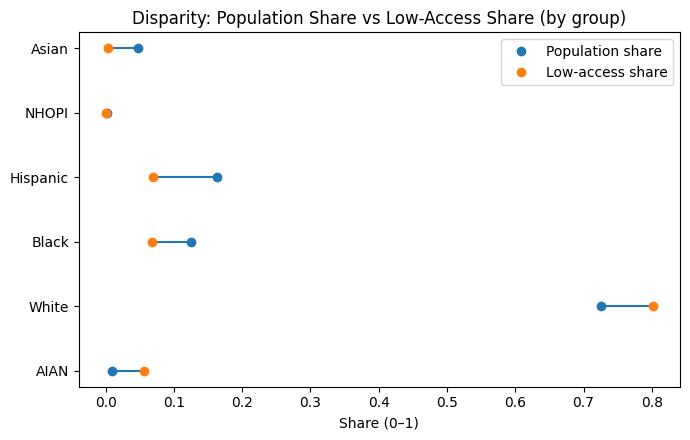

In [59]:
rows = []
# Denominator for "share among low-access": sum of all included groups' LA counts
la_den = sum(final_atlas_df[v['la']].fillna(0).sum() for v in groups.values())

#Looping through groups to calculate population share, low-access share, and parity
for name, cols in groups.items():
    la = final_atlas_df[cols['la']].fillna(0).sum()
    pop_share = (final_atlas_df['Pop2010'] * (final_atlas_df[cols['pct']]/100)).sum() / final_atlas_df['Pop2010'].sum()
    la_share  = la / la_den if la_den else 0
    rows.append({'group': name, 'pop_share': pop_share, 'la_share': la_share, 'parity': (la_share / pop_share) if pop_share else None})

dd = pd.DataFrame(rows).sort_values('parity', ascending=False)
plt.figure(figsize=(7,4.5))
y = range(len(dd))
plt.hlines(y, dd['pop_share'], dd['la_share'])
plt.plot(dd['pop_share'], y, 'o', label='Population share')
plt.plot(dd['la_share'],  y, 'o', label='Low-access share')
plt.yticks(y, dd['group'])
plt.xlabel('Share (0–1)')
plt.title('Disparity: Population Share vs Low-Access Share (by group)')
plt.legend()
plt.tight_layout(); plt.show()

##### Our visual showcases the disparity between the demographic population make up and the demographic low access population make up. We see that the Asian, Hispanic, and black population share is lower than their low access share. This is a surprise to me because I was expecting for minorities to generally have a higher low-access share of the economic setbacks they face. The White, AIAN (native), and NHOPI(Pacific Islander) population all have a larger low-access share than their population share. The AIAN and NHOPI having a larger low-access share is not as much as a surprise given the nature of their smaller population share and the economic difficulties minorities could face, however the White share disparity is a bit of a surprise. It might have to do with the innate nature of America's population makeup where the White population holds a majority but it's interesting to see them hold the majority for low-access share. Further analysis in the demographic make up of the White population would need to see the innate differences between the rural and urban section of their population, and to see if other low-access markers (½ mile, 20 mile, eg) would showcase otherwise. 


## Discussion

### Limitations

##### The data is limited through its use of area-level proxies for “food insecurity” rather than household surveys, so the data points are not representative of individual hunger. The dataset is also cross-sectional and ranges from multiple years and sources. This creates a chance for lags, measurement errors that could’ve occurred. A huge limitation for a dataset is that distance and urban/rural thresholds are approximations of access and ignore travel time, transit, prices, and store quality. Insights into those features would better help paint the picture of why there is food insecurity and the quality of food that is presented in areas. 


### Findings


##### At the start of our project we seeked to answer these questions: Who is affected by food insecurity?Why is food insecure in an area? What is the correlation between food insecurity and differing data points?. We analysed a data set provided by the USDA that gave insight into food insecurity metrics and demographic inside the USA. Through this dataset we saw correlation between food insecurity and poverty, food insecurity and the rural demographic, food insecurity and household income. This came as no surprise to me as food insecurity stems from economic struggle. Next we explored demographics and found that rural areas are disproportionately affected by food insecurity compared to urban areas. This stayed true for the 10 states with the most data points in the dataset and for aggregate of all other states. Giving us a clearer picture of who is most affected by food insecurity. Lastly we analyzed the demographic make up of those facing food insecurity and found that white, pacific islanders, and natives disproportionately experience food insecurity compared to other races. Through this analysis we are able to answer our questions and paint a clear picture of food insecurity across the states. 


### Impact

##### Identifying which demographic groups and places in the United States bear the greatest burden of food insecurity helps target resources and surface local barriers. At the same time, we should avoid over-relying on a single, area-level dataset: tract averages don’t describe individuals, and access proxies can miss prices, food quality, transportation, and safety. If we accept the dataset’s story uncritically, we risk overlooking other affected communities or misdiagnosing root causes. Complementary evidence—household-level surveys and measures of food quality, affordability, transportation access, and economic hardship—would provide a more consistent and accurate picture of who faces food insecurity and why.

### Resources 

https://seaborn.pydata.org/generated/seaborn.heatmap.html 

https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.background_gradient.html 

https://pandas.pydata.org/docs/user_guide/style.html 

https://plotly.com/python-api-reference/generated/plotly.express.imshow.html 

https://schoolofcities.github.io/urban-data-storytelling/urban-data-visualization/bivariate-choropleth-maps/bivariate-choropleth-maps.html

https://chatgpt.com/share/68c8d533-b9c8-8005-b9cd-c46dcb1bfed3

https://www.youtube.com/watch?v=0QLJduh1MNM This one is part 1 of a long series that helped a lot



